In [1]:
import os, sys
import general_config 
print(general_config.ROOTDIR)
sys.path.append(general_config.ROOTDIR)

import torch
import torch.nn as nn
import numpy as np
from model.adjusted_alexnet import AdjAlexnet

D:/Desktop@D/xai_basic


Last sequence of alexnet's linear layers <br>
  [0] <class 'torch.nn.modules.dropout.Dropout'>             (  0 children) False <br>
  [1] <class 'torch.nn.modules.linear.Linear'>               (  0 children) False <br>
  [2] <class 'torch.nn.modules.activation.ReLU'>             (  0 children) False <br>
  [3] <class 'torch.nn.modules.dropout.Dropout'>             (  0 children) False <br>
  [4] <class 'torch.nn.modules.linear.Linear'>               (  0 children) False <br>
  [5] <class 'torch.nn.modules.activation.ReLU'>             (  0 children) False <br>
  [6] <class 'torch.nn.modules.linear.Linear'>               (  0 children) False <br>

In [2]:
from captum.attr import IntegratedGradients ,GradientShap, Saliency, Occlusion, DeepLiftShap, InputXGradient
from captum.attr import DeepLift, GuidedBackprop, GuidedGradCam, Deconvolution, FeatureAblation 

In [3]:
import matplotlib.pyplot as plt
def create_comparison(x,heatmap, vmax=1.,vmin=1.,this_title=None):
    # x is torch tensor like (C,H,W)
    plt.figure(figsize=(12,12))
    counter = 1
    x1 = x.clone().detach().cpu().numpy().transpose(1,2,0)
    h1 = heatmap.clone().detach().cpu().numpy().transpose(1,2,0)
    for i in range(4):            
        plt.gcf().add_subplot(1,4,counter)
        if i == 0:
            plt.gca().imshow(x1)
            plt.title('%s'%(str(this_title)))
        else:
            # 3 channels of the heatmaps
            # print('h1:',np.max(h1),np.min(h1), h1.shape)
            plt.gca().imshow(h1[:,:,i-1], cmap='bwr', vmax=vmax,vmin=vmin) 
        counter += 1
    plt.show()

In [4]:
this_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    

N = 4
x = torch.tensor(np.random.uniform(0,1,size=(N,3,224,224))).to(torch.float).to(device=this_device)
x[:2,1,100:120,100:120] = x[:2,1,100:120,100:120]* 0. + 1.
y0 = [0,0,1,1] # np.random.randint(2,size=(N,))
print(y0)

[0, 0, 1, 1]


In [5]:
net = AdjAlexnet().to(device=this_device)
y = net(x)
print(y.shape)

torch.Size([4, 10])


In [6]:
def quick_setup(attrmodel, x,y, option=None):
    x.requires_grad=True
    net.zero_grad()
    for i in range(len(x)): # iterate thru batch number (otherwise too memory consuming)
        if option == 'GradientShap':
            baseline_dist = torch.randn(x.shape).to(device=this_device) * 0.001
            attr = attrmodel.attribute(x[i:i+1], target = y0[i], baselines=baseline_dist)
        elif option == 'DeepLifShap':
            baseline_dist = torch.randn(x.shape).to(device=this_device) * 0.001
            attr = attrmodel.attribute(x[i:i+1], target = y0[i], baselines=baseline_dist)
        elif option == 'Occlusion':
            attr = attrmodel.attribute(x[i:i+1], target = y0[i], sliding_window_shapes=(3,40, 40),strides = (3, 20,20))
        elif option == 'FeatureAblation':
            feature_mask = torch.tensor(0.1*np.ones((3,64,64))).to(torch.int64).to(device=this_device)
            attr = attrmodel.attribute(x[i:i+1], target = y0[i], feature_mask=feature_mask)
        else:
            attr = attrmodel.attribute(x[i:i+1], target = y0[i])

        this_min, this_max = torch.max(attr).item(), torch.min(attr).item()
        heatmap_magnitude = np.max((np.abs(this_min), np.abs(this_max)))
        print('attr.shape:%s, max:%s, min:%s'%(str(attr.shape), str(this_max),str(this_min)))
        this_title = 'hmag:%s'%(str(np.round(heatmap_magnitude,5)))
        create_comparison(x[i].cpu(),heatmap=attr[0], vmax=heatmap_magnitude,vmin=-heatmap_magnitude,
                          this_title=this_title) # grads still in (1,C,H,W)

## 1.
net.zero_grad()
quick_setup(IntegratedGradients(net), x.clone().detach(), y0)

## 2
net.zero_grad()
quick_setup(Saliency(net), x.clone().detach(), y0)

## 3.
net.zero_grad()
quick_setup(DeepLift(net), x.clone().detach(), y0)

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.0006320627289824188, min:0.000617861922364682


C:\Users\erico\AppData\Roaming\Python\Python36\site-packages\captum\attr\_core\deep_lift.py:301: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


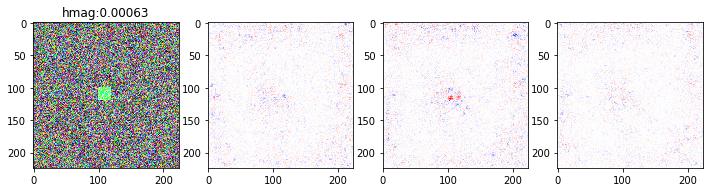

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.000516813772264868, min:0.000825879571493715


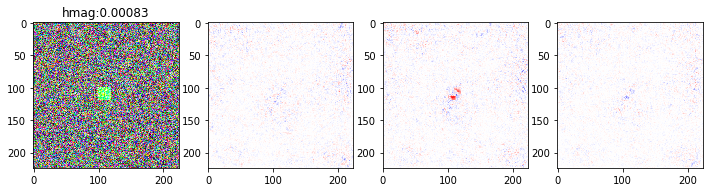

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.0005862630205228925, min:0.000867679133079946


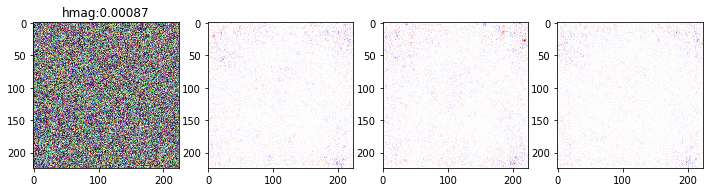

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.0005628553335554898, min:0.0006987933302298188


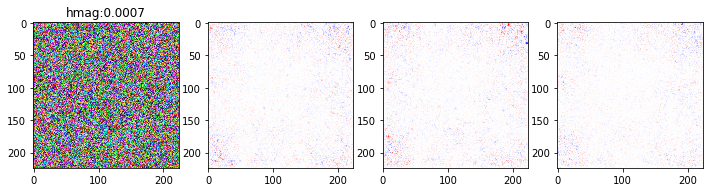

In [7]:
## 4.
net.zero_grad()
quick_setup(DeepLiftShap(net), x.clone().detach(), y0, option='DeepLifShap')

## 5.
net.zero_grad()
quick_setup(GradientShap(net), x.clone().detach(), y0, option='GradientShap')

## 6.
net.zero_grad()
quick_setup(InputXGradient(net), x.clone().detach(), y0, )

## 7.
net.zero_grad()
quick_setup(GuidedBackprop(net), x.clone().detach(), y0, )

## 8.
net.zero_grad() 
quick_setup(GuidedGradCam(net, getattr(net.backbone.features,'0')), x.clone().detach(), y0, )

C:\Users\erico\AppData\Roaming\Python\Python36\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


attr.shape:torch.Size([1, 3, 224, 224]), max:-0.04188825190067291, min:0.0459582544863224


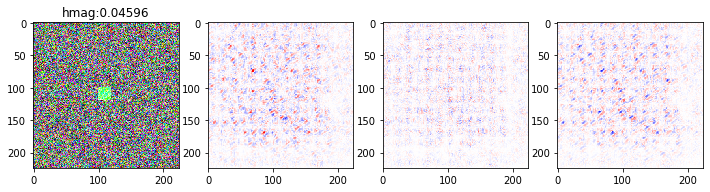

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.04024443402886391, min:0.048951633274555206


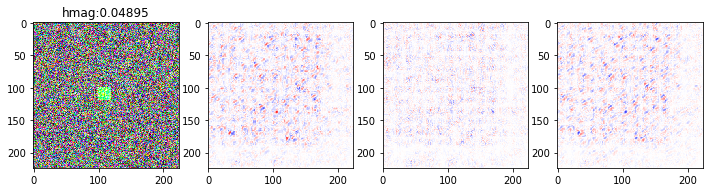

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.04656750708818436, min:0.05312500149011612


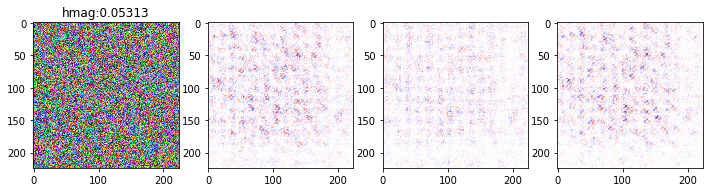

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.042496051639318466, min:0.04137052595615387


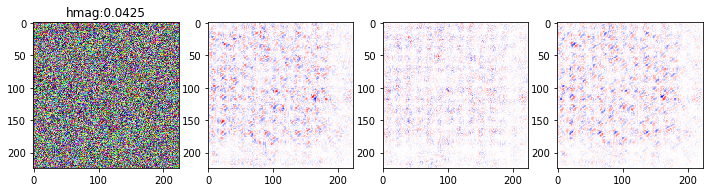

In [8]:
## 9.
net.zero_grad()
quick_setup(Deconvolution(net), x.clone().detach(), y0, )